# Get Started with Keras 3.0 + MLflow
**Author:** Jesse Chan<br>
**Date created:** 2023/11/05<br>
**Last modified:** 2023/11/05<br>

This tutorial is an end-to-end tutorial on training a MINST classifier with **Keras 3.0** and logging results with **Mlflow**. It will demonstrate the use of `mlflow.keras_core.MLflowCallback`, and how to subclass it to implement custom logging logic.

**Keras** is a high-level api that is designed to be simple, flexible, and powerful - allowing everyone from beginners to advanced users to quickly build, train, and evaluate models. **Keras 3.0**, or Keras Core, is a full rewrite of the Keras codebase that rebases it on top of a modular backend architecture. It makes it possible to run Keras workflows on top of arbitrary frameworks — starting with TensorFlow, JAX, and PyTorch.

## Install Packages

In [0]:
!pip install -q keras-core mlflow jax jaxlib torch tensorflow

## Import Packages / Configure Backend
Keras 3.0 is inherently multi-backend, so you will need to set the backend environment variable **before** importing the package.

In [0]:
import os
# You can use 'tensorflow', 'torch' or 'jax' as backend. Make sure to set the environment variable before importing.
os.environ["KERAS_BACKEND"] = "torch" 
import keras_core
import mlflow
import numpy as np

Using PyTorch backend.

## Load Dataset
We will use the MNIST dataset. This is a dataset of handwritten digits and will be used for an image classification task. There are 10 classes corresponding to the 10 digits.

In [0]:
(x_train, y_train), (x_test, y_test) = keras_core.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train[0].shape

Out[3]: (28, 28, 1)

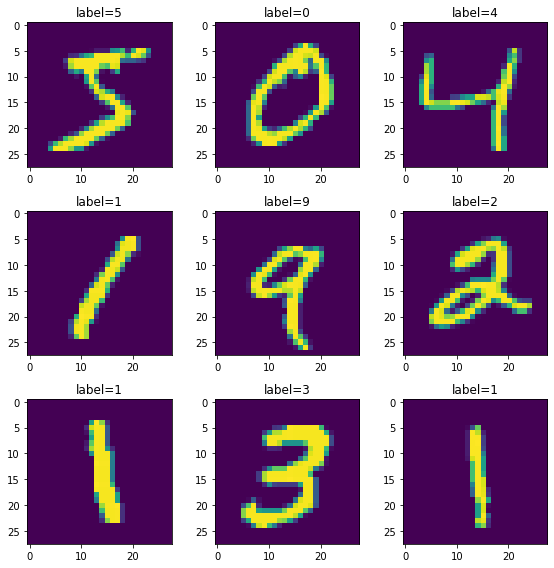

In [0]:
# Visualize Dataset
import matplotlib.pyplot as plt
grid = 3
fig, axes = plt.subplots(grid, grid, figsize=(8, 8))
for i in range(grid):
  for j in range(grid):
    axes[i][j].imshow(x_train[i * grid + j])
    axes[i][j].set_title(f"label={y_train[i * grid + j]}")
plt.tight_layout()

## Build Model
We will use the Keras 3.0 sequential API to build a simple CNN.

In [0]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28, 1)

def initialize_model():
  model = keras_core.Sequential([
    keras_core.Input(shape=INPUT_SHAPE),
    keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras_core.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras_core.layers.GlobalAveragePooling2D(),
    keras_core.layers.Dense(NUM_CLASSES, activation="softmax")
    ]
  )

  model.compile(
    loss=keras_core.losses.SparseCategoricalCrossentropy(),
    optimizer=keras_core.optimizers.Adam(),
    metrics=["accuracy"]
  )
  return model

model = initialize_model()
model.summary()

Model: "sequential" 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type) ┃ Output Shape ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d ( Conv2D ) │ ( None , 26 , 26 , 32 ) │ 320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 ( Conv2D ) │ ( None , 24 , 24 , 32 ) │ 9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 ( Conv2D ) │ ( None , 22 , 22 , 32 ) │ 9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d │ ( None , 32 ) │ 0 │
│ ( GlobalAveragePooling2D ) │ │ │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense ( Dense ) │ ( None , 10 ) │ 330 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 19,146 (74.79 KB)

 Trainable params: 19,146 (74.79 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model (Default Callback)
We will fit the model on the dataset, using Mlflow's `mlflow.keras_core.MLflowCallback` to log metrics during training.

In [0]:
BATCH_SIZE = 64 # adjust this based on the memory of your machine
EPOCHS = 3

### Log Per Epoch
An epoch defined as one pass through the entire training dataset.

In [0]:
model = initialize_model()

with mlflow.start_run() as run:
  model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.1, 
    callbacks=[mlflow.keras_core.MLflowCallback(run)]
  )

Epoch 1/3
 1/844 ━━━━━━━━━━━━━━━━━━━━ 1:36 114ms/step - accuracy: 0.0938 - loss: 12.5421 4/844 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.0840 - loss: 9.6917  7/844 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.0854 - loss: 8.3299 10/844 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.0880 - loss: 7.4552 13/844 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.0906 - loss: 6.8269 16/844 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.0925 - loss: 6.3570 19/844 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.0954 - loss: 5.9831 22/844 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.0984 - loss: 5.6769 24/844 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.1006 - loss: 5.5017 27/844 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.1043 - loss: 5.2732 30/844 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.1084 - loss: 5.0775 32/844 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.1110 - loss: 4.9619 34/844 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.1134 - loss: 4.8561 37/844 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.1174 - loss: 4.7130 40/844 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.1214 - loss: 4.5857 43/844 ━ ━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.1252 - loss: 4.4715  46/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1289 - loss: 4.3682 49/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1327 - loss: 4.2742 52/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1364 - loss: 4.1883 55/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1400 - loss: 4.1092 58/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1434 - loss: 4.0364 61/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1468 - loss: 3.9687 64/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1500 - loss: 3.9057 67/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1531 - loss: 3.8466 70/844 ━ ━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1560 - loss: 3.7913 73/844 ━ ━━━━━━━━━━━━━━━━━━━

The callback for the run would log **parameters**, **metrics** and **artifacts** to Mlflow dashboard.

<img src="https://drive.google.com/uc?export=view&id=1oyniWK6YS2v6vV8W-ZozX7HdRMCOMH0B" alt="run page" width="1000"/>

### Log Per Batch
Within each epoch, the training dataset is broken down to batches based on the defined `BATCH_SIZE`. If we set the callback to not log based on epochs with `log_every_epoch=False`, and to log every 5 batches with `log_every_n_steps=5`, we can adjust the logging to be based on the batches.

In [0]:
model = initialize_model()

with mlflow.start_run() as run:
  model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.1, 
    callbacks=[mlflow.keras_core.MLflowCallback(run, log_every_epoch=False, log_every_n_steps=5)]
  )

Epoch 1/3
 1/844 ━━━━━━━━━━━━━━━━━━━━ 1:26 102ms/step - accuracy: 0.0938 - loss: 10.9629 4/844 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.0990 - loss: 10.1350  5/844 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.1035 - loss: 9.8461  7/844 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.1086 - loss: 9.3007 9/844 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.1094 - loss: 8.8405 11/844 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.1092 - loss: 8.4213 13/844 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.1094 - loss: 8.0405 16/844 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.1108 - loss: 7.5489 19/844 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.1128 - loss: 7.1315 22/844 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.1142 - loss: 6.7762 25/844 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.1153 - loss: 6.4719 28/844 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1169 - loss: 6.2091 31/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1187 - loss: 5.9802 33/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1201 - loss: 5.8431 35/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1218 - loss: 5.7166 37/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1235 - loss: 5.5994 39/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1256 - loss: 5.4904 41/844 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.1277 - loss: 5.3889 44/844 ━ ━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.1306 - loss: 5.2491  45/844 ━ ━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.1316 - loss: 5.2054 48/844 ━ ━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.1344 - loss: 5.0820 51/844 ━ ━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.1372 - loss: 4.9691 54/844 ━ ━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.1401 - loss: 4.8653 57/844 ━ ━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.1431 - loss: 4.7693 59/844 ━ ━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.1451 - loss: 4.7093 61/844

If we log per epoch, we will only have three datapoints, since there are only 3 epochs:
<img src="https://drive.google.com/uc?export=view&id=15yaFxqr-EZ1E249R6IttVrYi75MGkeVA" alt="log per epoch" width="1000"/>

By logging per batch, we can get more datapoints, but they can be noisier:

<img src="https://drive.google.com/uc?export=view&id=10-lqxtJudFcYREhCQkzgBh2l9kIsCcEt" alt="log per batch" width="1000"/>


## Train Model (Custom Callback)
Let's train the model again, for the purpose of demonstrating how to use subclass and customize Mlflow's `mlflow.keras_core.MLflowCallback` for logging. 

The pre-defined `MLflowCallback` allows us to adjust whether we want to log every epoch or every batch through parameters `log_every_epoch` and `log_every_n_steps`. However, currently each time the callback logs is defined as a `step`, so if we log every 5 batches, it will just be 1 step. What if we want the steps to correspond exactly to the batches seen?

Notice that the logging that happens every 5 batches is logged as one step along the x-axis:

<img src="https://drive.google.com/uc?export=view&id=1MJpx-w4UFeXHjlVCpwp0PThRAZRYhxy-" alt="5 batches per step" width="500"/>

The method we will look at is `on_batch_end()`. This method is a callback that is called at the end of every batch. `self._log_step` counts the logging steps and is shown as one of the x-axis on the graph.

```
def on_batch_end(self, batch, logs=None):
  """Log metrics at the end of each batch with user specified frequency."""
  if self.log_every_n_steps is None or logs is None:
      return
  if (batch + 1) % self.log_every_n_steps == 0:
      self.metrics_logger.record_metrics(logs, self._log_step)
      self._log_step += 1
```

In [0]:
class MlflowCallbackLogPerBatch(mlflow.keras_core.MLflowCallback):
  def on_batch_end(self, batch, logs=None):
    if self.log_every_n_steps is None or logs is None:
      return
    if (batch + 1) % self.log_every_n_steps == 0:
      self.metrics_logger.record_metrics(logs, self._log_step)
      self._log_step += self.log_every_n_steps

In [0]:
model = initialize_model()

with mlflow.start_run() as run:
  model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_split=0.1, 
    callbacks=[MlflowCallbackLogPerBatch(run, log_every_epoch=False, log_every_n_steps=5)]
  )

Epoch 1/3
 1/844 ━━━━━━━━━━━━━━━━━━━━ 1:36 115ms/step - accuracy: 0.1094 - loss: 10.5078 3/844 ━━━━━━━━━━━━━━━━━━━━ 24s 29ms/step - accuracy: 0.0894 - loss: 8.9696  5/844 ━━━━━━━━━━━━━━━━━━━━ 56s 67ms/step - accuracy: 0.0821 - loss: 7.9605 7/844 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - accuracy: 0.0798 - loss: 7.2270 10/844 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.0832 - loss: 6.4575 13/844 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - accuracy: 0.0847 - loss: 5.9239 15/844 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.0856 - loss: 5.6469 17/844 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.0872 - loss: 5.4134 19/844 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.0889 - loss: 5.2135 21/844 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - accuracy: 0.0908 - loss: 5.0402 23/844 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0926 - loss: 4.8881 25/844 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.0947 - loss: 4.7533 27/844 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.0967 - loss: 4.6331 29/844 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.0985 - loss: 4.5252 31/844 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.1004 - loss: 4.4277 33/844 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.1020 - loss: 4.3391 35/844 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.1034 - loss: 4.2583 38/844 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.1057 - loss: 4.1488 41/844 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.1080 - loss: 4.0516 44/844 ━ ━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.1103 - loss: 3.9643  47/844 ━ ━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.1129 - loss: 3.8854 50/844 ━ ━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1158 - loss: 3.8136 53/844 ━ ━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.1187 - loss: 3.7478 56/844 ━ ━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.1215 - loss: 3.6873 59/844 ━ ━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.1242 - loss: 3.6312 6

Observe that with the customized callback, the steps correspond directly to the number of batches seen. 1 batch corresponds to 1 step.

<img src="https://drive.google.com/uc?export=view&id=152VDpc9r8sW4_SV3MZ-kjkNFQVhvy4M3" alt="1 batch per step" width="500"/>

## Evaluation
Similar to training, you can use the callback to log the evaluation result.

In [0]:
with mlflow.start_run() as run:
  model.evaluate(x_test, y_test, callbacks=[mlflow.keras_core.MLflowCallback(run)])

1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9375 - loss: 0.1264 10/313 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9643 - loss: 0.1030 19/313 ━ ━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9606 - loss: 0.1205  28/313 ━ ━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9555 - loss: 0.1362 37/313 ━━ ━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9527 - loss: 0.1458 48/313 ━━━ ━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9492 - loss: 0.1555 59/313 ━━━ ━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9466 - loss: 0.1628 68/313 ━━━━ ━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9451 - loss: 0.1676 78/313 ━━━━ ━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9435 - loss: 0.1726 87/313 ━━━━━ ━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9425 - loss: 0.1760 96/313 ━━━━━━ ━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9418 - loss: 0.1783 106/313 ━━━━━━ ━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9414 - loss: 0.1800 117/313 ━━━━━━━ ━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9412 - loss: 0.1810 127/313 ━━━━━━━━ ━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9411 - loss: 0.1818 138/313 ━━━━━━━━ ━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9410 - loss: 0.1825 149/313 ━━━━━━━━━ ━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9410 - loss: 0.1832 159/313 ━━━━━━━━━━ ━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9410 - loss: 0.1837 170/313 ━━━━━━━━━━ ━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9411 - loss: 0.1838 180/313 ━━━━━━━━━━━ ━━━━━━━━━ 0s 5ms/step - accuracy: 0.9414 - loss: 0.1836 191/313 ━━━━━━━━━━━━ ━━━━━━━━ 0s 5ms/step - accuracy: 0.9417 - loss: 0.1831 202/313 ━━━━━━━━━━━━ ━━━━━━━━ 0s 5ms/step - accuracy: 0.9420 - loss: 0.1825 213/313 ━━━━━━━━━━━━━ ━━━━━━━ 0s 5ms/step - accuracy: 0.9422 - loss: 0.1820 224/313 ━━━━━━━━━━━━━━ ━━━━━━ 0s 5ms/step - accuracy: 0.9424 - loss: 0.1815 235/313 ━━━━━━━━━━━━━━━ ━━━━━ 0s 5ms/step - accuracy: 0.9427 - loss: 0.1808 245/313 ━━━━━━━━━━━━━━━ ━━━━━ 0s 5ms/step - accuracy: 0.9429 - loss: 0.1801 255/313 ━━━━━━━━━━━━━━━━ ━━━━ 0s 5ms/step - accuracy: 0.9432 - loss: 0.1794 263/313 ━━━━━━━━━━━━━━━━ ━━━━ 0s 5ms/step - accuracy: 0.9434 - loss: 0.